# Create Synthetic Weather

### Attempting to implement Synthetic Weather Scripts in TensorFlow. 

Order is as follows: 

1. Pre-process time series as required. (e.g., convert temperature to absolute)
2. Fit Fourier terms, i.e., regression with sine and cosine.
3. Fit SARMA model to residual from Fourier fit. Alternatives to SARMA?
4. Bootstrap residual of SARMA model fitting (call it noise). Create synthetic noise.
5. Simulate SARMA (or alternative) with synthetic noise. This gives us synthetic variations of Fourier residuals.
6. Add correlated synthetic residuals back to Fourier terms. This gives us synthetic variations of original series.
7. Run sanity checks and smooth if "ridiculous" values are seen. (what is a ridiculous value?)

### NB: This script, if run on Windows, calls R from the command line and waits for output. That is a pretty slow process. If you run this in linux, it will call R inside python using rpy2.

In [1]:
"""
This file can be used to install all of the libraries that would be needed to run the CreateSyntheticWeather.py
script. This doesn't need to be run everytime - just once. This script assumes you do not have admin rights on the
machine. If you do have admin rights, and wish to install the python packages for everybody, then remove the options
'--user' from the pip.install command.

DISABLE THIS AFTER THE FIRST RUN.
"""

# import subprocess

# __author__ = 'Parag Rastogi'

# subprocess.run('pip.install --user numpy scipy pandas matplotlib', shell=True) # Remove '--user' for an admin install
# subprocess.run('pip.install numpy scipy pandas matplotlib', shell=True)

# # Write an R file to install the forecast package. The repo used is a global repo redirect.
# # If the link doesn't work, then this script will fail. In that case, change the repo and try again.

# f = open('install-packages.r', 'w', encoding='utf8')

# # The original of the code written below is at https://orfe.princeton.edu/help/r-packages
# f.write('## Create the personal library if it doesn''t exist. Ignore a warning if the directory already exists.\n' +
#         'dir.create(Sys.getenv("R_LIBS_USER"), showWarnings = FALSE, recursive = TRUE)\n' +
#         '## Install one package.\n' +
#         'install.packages("forecast", Sys.getenv("R_LIBS_USER"), repos = "http://cloud.r-project.org")\n' +
#         # The rest are other types of installations. Only included here for reference.
#         '## Install a package that you have copied to the remote system.\n' +
#         '## install.packages("file_name.tar.gz", Sys.getenv("R_LIBS_USER")\n' +
#         '## Install multiple packages.\n' +
#         '## install.packages(c("timeDate","robustbase"), Sys.getenv("R_LIBS_USER"), ' +
#         'repos = "http://cloud.r-project.org")")')

# f.close()

# # # Compose the R command
# rcmd = 'R CMD BATCH install-packages.r '
# subprocess.run(rcmd)

"\nThis file can be used to install all of the libraries that would be needed to run the CreateSyntheticWeather.py\nscript. This doesn't need to be run everytime - just once. This script assumes you do not have admin rights on the\nmachine. If you do have admin rights, and wish to install the python packages for everybody, then remove the options\n'--user' from the pip.install command.\n\nDISABLE THIS AFTER THE FIRST RUN.\n"

In [2]:
"""This is a port of the script originally written with my thesis.
   Script originally written by Parag Rastogi.
"""

import numpy as np
# import matplotlib.pyplot as plt
import os.path
import pandas as pd
import scipy as sp
from scipy import optimize
# from scipy import io  # This is to read MAT files.
import code
import fourier_fit_funcs as fourier
import SimArima
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# This is just to time the execution of the script. Doesn't serve any programmatic purpose.
from datetime import datetime
startTime = datetime.now()

__author__ = 'Parag Rastogi'

print('Welcome to the Synthetic Weather Time Series Generator, v0\r\n')
print('For now, this script only demonstrates the method for GENEVA.\r\n')

# Set Default Colours
import default_colours as colour

Welcome to the Synthetic Weather Time Series Generator, v0

For now, this script only demonstrates the method for GENEVA.



In [28]:
if os.name == 'nt':
    print('Running on Windows.\r\n')
elif os.name == 'unix':
    print('Running on Linux - loading rpy.\r\n')
    try:
        import rpy2 as rpy2
    except ImportError:
         printf("I couldn't find rpy2. Please install it first.\r\n") 
            # module doesn't exist, deal with it.

Running on Windows.



In [3]:
# # FILE PATHS.

# location = input('Please enter the name of the location you will be '
#                  'working with today. The first three letters of the '
#                  'string entered will be used as the location/region label.'
#                  '\r\n')
location = 'GENEVA'
# If the location is entered with lower case letters, convert it to upper case.
loccode = location.upper()[0:3]

# This is the letter of the drive where the files and data are/will be
# drive = 'e:\\'
# This is the path to the file - separated by folder and file name.
pathInEPWfldr = os.path.join('..', 'WeatherData', 'HistoricData', 'GEN')
nameInEPWfile = 'GEN_IWEC.epw'
pathInEPWfile = os.path.join(pathInEPWfldr, nameInEPWfile)


In [4]:
# # READ the short weather time series you gave the program. I expect only one file.
# For now, I can only read the EPW format, though 

# These are the names of the columns in EPW files
colnames = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'QualFlags',
            'TDB', 'TDP', 'RH', 'ATMPR', 'ETRH', 'ETRN', 'HIR', 'GHI',
            'DNI', 'DHI', 'GHE', 'DNE', 'DHE', 'ZL', 'WDR', 'WSPD', 'TSKY',
            'OSKY', 'VIS', 'CHGT', 'PWO', 'PWC', 'PWT', 'AOPT', 'SDPT',
            'SLAST', 'UnknownVar1', 'UnknownVar2', 'UnknownVar3']
# Convert the names to be in lowercase
colnames = [x.lower() for x in colnames]
tmytable = pd.read_csv(pathInEPWfile, delimiter=',', skiprows=8,
                       header=None, names=colnames)

# Initialise time index variables
N = tmytable.shape[0]  # Should be 8760
t = np.linspace(1, N, endpoint=True, num=N)  # Julian Hour Index
nm = 12  # Number of months
# mt = (2015,1,1) # Month number

In [5]:
# These are the 'raw' time series, i.e., read from the EPW file.
# raws = dict(tdb=np.array(tmytable.tdb) + 273.15, rh=np.array(tmytable.rh), ghi=np.array(tmytable.ghi),
#             dni=np.array(tmytable.dhi), dhi=np.array(tmytable.dhi))
raws = tmytable[['tdb','tdp','rh','ghi','dni','wdr','wspd','atmpr']].values
raws[:,0] = raws[:,0] + 273.15

# TDB -> Temperature, Dry-bulb (degC -> K)
# RH -> Relative Humidity (%)
# GHI -> Global Horizontal Solar Radiation [Wh/m2]
# DNI -> Direct Normal Solar Radiation [Wh/m2]
# DHI -> Diffuse Horizontal Solar Radiation [Wh/m2]

# Limit below which a reading is considered to be ZERO
ghi_limit = 1  # w/m2
# This limit applies to all solar radiation quantities.
# That is to say that if the global horizontal radiation
# was effectively zero, everything else will be zero too.

ghicensor = raws[:,3] <= ghi_limit
raws[:,3][np.ix_(ghicensor)] = 0
raws[:,4][np.ix_(ghicensor)] = 0
# raws[:,4][np.ix_(ghicensor)] = 0

In [6]:
# Fit periodic regression terms (Fourier fit). This invokes another script called fourier_fit_funcs as fourier.

# The curve_fit function outputs two things:
params = {'tdb': sp.optimize.curve_fit(fourier.fit_tdb, t, raws[:,0]),
          'rh': sp.optimize.curve_fit(fourier.fit_rh, t, raws[:,2]),
          'tdb_low': sp.optimize.curve_fit(fourier.fit_tdb_low, t,
                                           raws[:,0]),
          'tdb_high': sp.optimize.curve_fit(fourier.fit_tdb_high, t,
                                            raws[:,0]),
          'rh_low': sp.optimize.curve_fit(fourier.fit_rh_low, t, raws[:,2])}

# Call the fourier fit function with the calculated parameters to get the
# values of the fourier fit at each time step
# ffit = {'tdb': fourier.fit('tdb', t, *params['tdb'][0]),
#         'rh': fourier.fit('rh', t, *params['rh'][0]),
#         'tdb_low': fourier.fit('tdb_low', t, *params['tdb_low'][0]),
#         'tdb_high': fourier.fit('tdb_high', t, *params['tdb_high'][0]),
#         'rh_low': fourier.fit('rh_low', t, *params['rh_low'][0])}
ffit = (np.vstack((fourier.fit('tdb', t, *params['tdb'][0]),
                           fourier.fit('rh_low', t, *params['rh_low'][0])))).T

# np.rot90(,1)
# Now subtract the low- and high-frequency fourier fits
# (whichever is applicable) from the raw values to get the
# 'de-meaned' values (values from which the mean has been removed).
demeaned = raws[:,0:2] - ffit

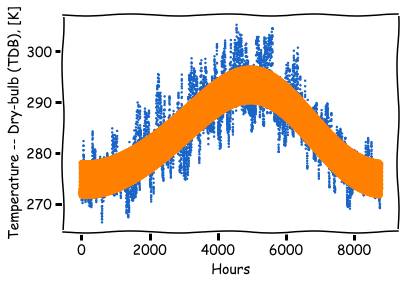

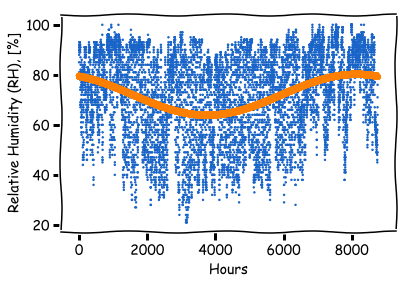

In [17]:
plt.xkcd()
p1 = plt.scatter(t, raws[:,0], marker='o')
p1.set_sizes(2*np.ones((8760,), dtype=np.int))
p1.set_color(colour.blue)
p2 = plt.scatter(t, ffit[:,0],linestyle = '--')
p2.set_color(colour.orange)
plt.xlabel('Hours')
plt.ylabel('Temperature -- Dry-bulb (TDB), [K]')
plt.show()

p3 = plt.scatter(t, raws[:,2], marker='o')
p3.set_sizes(2*np.ones((8760,), dtype=np.int))
p3.set_color(colour.blue)
p4 = plt.scatter(t, ffit[:,1], linestyle = '--')
p4.set_color(colour.orange)
plt.xlabel('Hours')
plt.ylabel('Relative Humidity (RH), [%]')
plt.show()

In [18]:
# Now subtract the low- and high-frequency fourier fits
# (whichever is applicable) from the raw values to get the
# 'de-meaned' values (values from which the mean has been removed).
demeaned = raws[:,0:2]-ffit

In [19]:
demeaned

array([[ -1.74718795e+00,  -8.43046801e+01],
       [ -6.89718073e-01,  -8.31021477e+01],
       [ -2.38849707e-02,  -8.22996114e+01],
       ..., 
       [ -5.50635588e+00,  -8.81122548e+01],
       [ -4.50160492e+00,  -8.71097337e+01],
       [ -3.16517093e+00,  -8.57072088e+01]])

In [ ]:
# # Declare the parameters that will be fed to the R script.
# # If arp or maq>1, then the R script will try to fit models
# # with each combination of arp and maq.
# # The script will then output the best model (based on smallest BIC).
# arp = 4
# maq = 4
# sarp = 1
# smaq = 1
# npaths = 50

# # This is where the choice between models should be made. 
# # I am using a model with 4+4+1+1 parameters. 
# # I should be examining the performance of models that have
# # *between* 0 and 4 AR parameters, 0-4 MA parameters, etc.

# # Write the de-meaned data series to CSV file.
# # Path to file.
# pathTSdm = os.path.join(pathInEPWfldr,
#                         '{0}_dm.csv'.format(nameInEPWfile[0:-4]))

# # Construct a 2D array to write to csv file
# dm = np.zeros((demeaned['tdb'].shape[0], 2))
# dm[:, 0] = demeaned['tdb']
# dm[:, 1] = demeaned['rh']

# np.savetxt(pathTSdm, dm, delimiter=',', fmt='%f')

In [ ]:
# print('Calling the R script... \r\n')

# # Call R inside the following script
# [bsout, modlist] = SimArima.callrcmd(pathTSdm, arp, maq, sarp, smaq, npaths)

In [ ]:
# rfile = open('SimArima.r', 'r')
# print(rfile)

In [ ]:
# # Add the results from simulating the SARMA model (i.e.,
# # the output from R) back to the seasonal/fourier fits that
# # were removed from the original data earlier.
# tdbrecon = np.zeros(bsout['tdb'].shape)

# # code.interact(local={**locals(), **globals()})

# for path in range(0, bsout['tdb'].shape[1], 1):
#     tdbrecon[:, path] = ffit['tdb'] + bsout['tdb'][:, path]

# rhrecon = np.zeros(bsout['rh'].shape)
# for path in range(0, bsout['rh'].shape[1], 1):
#     rhrecon[:, path] = ffit['rh'] + bsout['rh'][:, path]

# arma_deg = dict(tdb=modlist['tdb'][0].split(' '),
#                 rh=modlist['rh'][0].split(' '))
# for e in range(0, len(arma_deg['tdb'])):
#     arma_deg['tdb'][e] = int(arma_deg['tdb'][e])
# for e in range(0, len(arma_deg['rh'])):
#     arma_deg['rh'][e] = int(arma_deg['rh'][e])

# arma_coeff = dict(tdb=modlist['tdb'][1].split(' '),
#                   rh=modlist['rh'][1].split(' '))
# for e in range(0, len(arma_coeff['tdb'])):
#     arma_coeff['tdb'][e] = float(arma_coeff['tdb'][e])
# for e in range(0, len(arma_coeff['rh'])):
#     arma_coeff['rh'][e] = float(arma_coeff['rh'][e])

# # Create a dictionary to save the ARMA model
# ARmodel = dict(tdb=dict(degrees=arma_deg['tdb'], coeffs=arma_coeff['tdb'],
#                         bic=float(modlist['tdb'][2])),
#                rh=dict(degrees=arma_deg['rh'], coeffs=arma_coeff['rh'],
#                        bic=float(modlist['rh'][2])))

# # This AR model should be written to a file so it can be shown to the user.

# # recon = {'tdb': tdbrecon, 'rh': rhrecon}

# # Write the synthetic outputs to files
# np.savetxt('tdb_syn.csv', tdbrecon)
# np.savetxt('rh_syn.csv', rhrecon)

# print('End of current script ....\r\n')
# print('Script took {0:0.1f} seconds'.format(datetime.now() - startTime))

# # Disabled to run on server.
# # Go to the command line with code.interact. The stuff inside the brackets is
# # to make sure that the variables are transmitted.


# # except (RuntimeError,TypeError,ValueError):
# #     # Go to the command line with code.interact.
# #     # The stuff inside the brackets is
# #     # to make sure that the variables are transmitted.
# # code.interact(local={**locals(), **globals()})